# Lab 3 

## Task 1: Harris Corner Detector

Flat region → intensity change small

Edge → change in one direction

Corner → change in both directions

In [1]:
# Install required packages

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from pathlib import Path
from scipy.ndimage import gaussian_filter, maximum_filter
import cv2

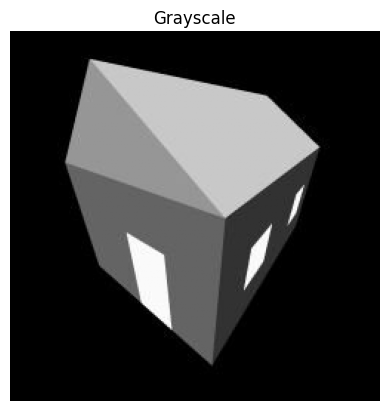

In [3]:
# Load image and convert to grayscale

img_path = Path("/Users/natalia/Documents/LTU_Master/Computer_vision/Lab3/lab3") / "left.jpg"
img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gray = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

# Show image
plt.figure()
plt.plot()
plt.imshow(img_gray, cmap = 'gray'); plt.title('Grayscale'); plt.axis('off')
plt.show()

### Harris Corner detector from scratch

Large R ⇒ corner, small R ⇒ flat, negative R ⇒ edge.

In [4]:
# Harris Corner detector

# Parameters 
def harris_corners(
    gray,                   # image in grayscale
    k=0.05,
    sigma=1.5,
    nms_ksize=3,
    corner_thresh_rel=0.05, # relative to max(R>0)
    edge_thresh_rel=0.05,   # relative to max(-R) for R<0
    refine=False
):
    """
    Returns:
        corners_xy : local maxima of R above corner_thresh
        edges_xy   : local minima of R below -edge_thresh
        R          : raw Harris response
        Rn         : normalized 0..1
    """

    # to float32 in [0,1]
    g = gray.astype(np.float32)
    if g.max() > 1:
        g /= 255.0

    # Sobel kernel 3x3
    Ix = cv2.Sobel(g, cv2.CV_32F, 1, 0, ksize=3, borderType=cv2.BORDER_REFLECT_101)
    Iy = cv2.Sobel(g, cv2.CV_32F, 0, 1, ksize=3, borderType=cv2.BORDER_REFLECT_101)

    # Tensor smoothing
    Ixx = cv2.GaussianBlur(Ix*Ix, (0,0), sigma)
    Iyy = cv2.GaussianBlur(Iy*Iy, (0,0), sigma)
    Ixy = cv2.GaussianBlur(Ix*Iy, (0,0), sigma)

    # Harris response
    detM   = Ixx*Iyy - Ixy*Ixy
    traceM = Ixx + Iyy
    R      = detM - k*(traceM**2)

    # normalized (for reference/plots)
    Rn = (R - R.min()) / (R.max() - R.min() + 1e-12)

    # NMS kernel
    if nms_ksize % 2 == 0:
        nms_ksize += 1
    kernel = np.ones((nms_ksize, nms_ksize), np.uint8)

    # CORNERS: local maxima of R, above threshold
    Rpos_max = max(float(R.max()), 0.0)
    c_thr = corner_thresh_rel * (Rpos_max + 1e-12)
    R_dil = cv2.dilate(R, kernel)  # local max filter
    corners_mask = (R == R_dil) & (R > c_thr)

    # EDGES: local minima of R (maxima of -R), below -threshold
    Rneg_max = float(np.max(-R))            # = -min(R)
    e_thr = edge_thresh_rel * (Rneg_max + 1e-12)
    m_dil = cv2.dilate(-R, kernel)          # local max of (-R) => local min of R
    edges_mask = ((-R) == m_dil) & (R < -e_thr)

    # Connected components -> centroids
    def centroids(mask):
        mask_u8 = mask.astype(np.uint8)
        num, _, _, cents = cv2.connectedComponentsWithStats(mask_u8, connectivity=8)
        return cents[1:].astype(int) if num > 1 else np.empty((0,2), int)

    corners_xy = centroids(corners_mask)
    edges_xy   = centroids(edges_mask)

    return corners_xy, edges_xy, R, Rn


corners_xy → local maxima of R above +corner_thresh

edges_xy   → local minima of R below -edge_thresh

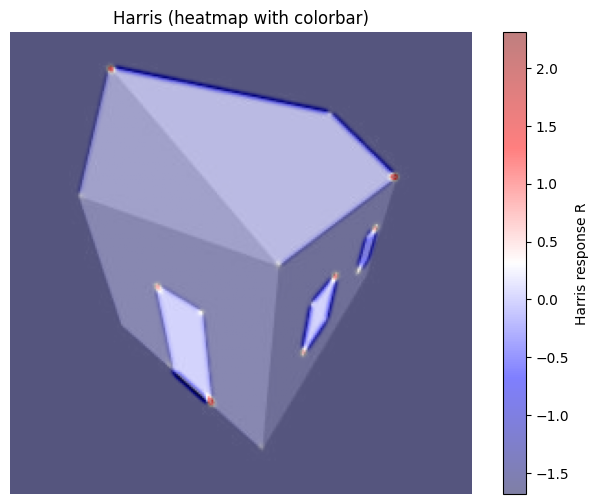

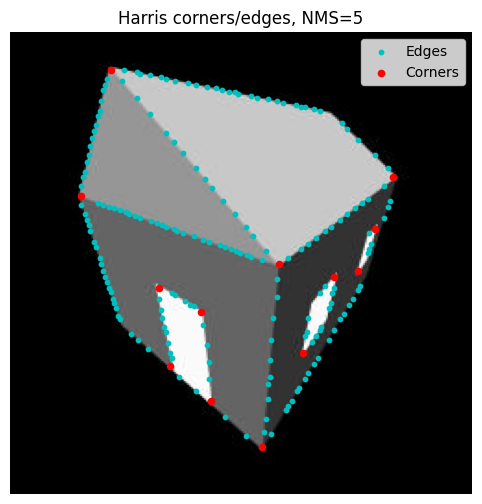

In [5]:
# Setting parameters for further plotting 

corners_xy, edges_xy, R, Rn = harris_corners(
    img_gray, k=0.05, sigma=1.5,
    nms_ksize=3,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.001,  
    refine=False
)


# Heatmap plot: R for sign-aware heatmap (red=positive corners, blue=negative edges)

plt.figure(figsize=(8,6))
plt.imshow(img_rgb)
plt.imshow(R, cmap='seismic', alpha=0.5)
cbar = plt.colorbar()
cbar.set_label('Harris response R')
plt.title("Harris (heatmap with colorbar)")
plt.axis('off')
plt.show()

# Scatter-plot for edges and corners 

plt.figure(figsize=(8,6))
plt.imshow(img_gray, cmap='gray')
if len(edges_xy):
    plt.scatter(edges_xy[:,0], edges_xy[:,1], s=10, c='c', label='Edges')
if len(corners_xy):
    plt.scatter(corners_xy[:,0], corners_xy[:,1], s=20, c='r', label='Corners')
plt.legend()
plt.title("Harris corners/edges, NMS=5")
plt.axis('off')
plt.show()


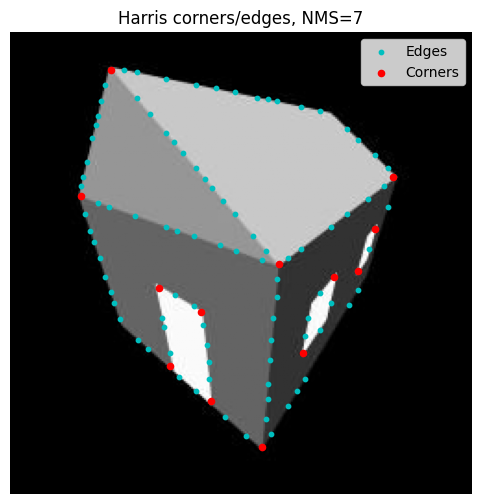

In [6]:
# Changing NMS (Non-Maximum Suppression)

corners_xy, edges_xy, R, Rn = harris_corners(
    img_gray, k=0.05, sigma=1.5,
    nms_ksize=7,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.001,  
    refine=False
)

# Scatter-plot for edges and corners 

plt.figure(figsize=(8,6))
plt.imshow(img_gray, cmap='gray')
if len(edges_xy):
    plt.scatter(edges_xy[:,0], edges_xy[:,1], s=10, c='c', label='Edges')
if len(corners_xy):
    plt.scatter(corners_xy[:,0], corners_xy[:,1], s=20, c='r', label='Corners')
plt.legend()
plt.title("Harris corners/edges, NMS=7")
plt.axis('off')
plt.show()


### Rotation 45°

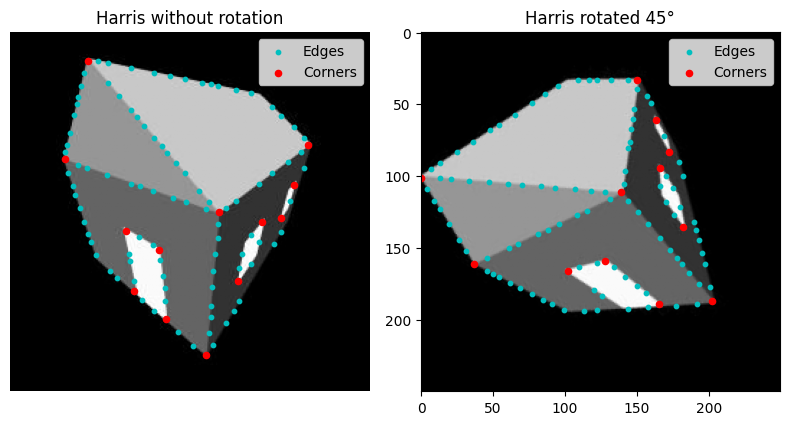

In [7]:
# corners on ORIGINAL
corners_xy, edges_xy, R, Rn = harris_corners(
    img_gray, k=0.05, sigma=1.5,
    nms_ksize=7,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.001,  
    refine=False
)

# Rotate by 45°
h, w = img_gray.shape

# rotate around the center (w/2, h/2)
M = cv2.getRotationMatrix2D((w/2, h/2), 45, 1.0)   # (center, angle_deg, scale)
img_gray_rot = cv2.warpAffine(img_gray, M, (w, h), flags=cv2.INTER_LINEAR)

# Corners on ROTATED
corners_rot, edges_rot, R_rot, Rn_rot = harris_corners(
    img_gray_rot, k=0.05, sigma=1.5,
    nms_ksize=7,
    corner_thresh_rel=0.05,
    edge_thresh_rel=0.001,
    refine=False
)

# Show
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
if len(edges_xy):
    plt.scatter(edges_xy[:,0], edges_xy[:,1], s=10, c='c', label='Edges')
if len(corners_xy):
    plt.scatter(corners_xy[:,0], corners_xy[:,1], s=20, c='r', label='Corners')
plt.legend()
plt.title("Harris without rotation")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_gray_rot, cmap='gray')
if len(edges_rot):
    plt.scatter(edges_rot[:,0], edges_rot[:,1], s=10, c='c', label='Edges')
if len(corners_rot):
    plt.scatter(corners_rot[:,0], corners_rot[:,1], s=20, c='r', label='Corners')
plt.legend()
plt.title("Harris rotated 45°")

plt.tight_layout()
plt.show()

###  Resize test

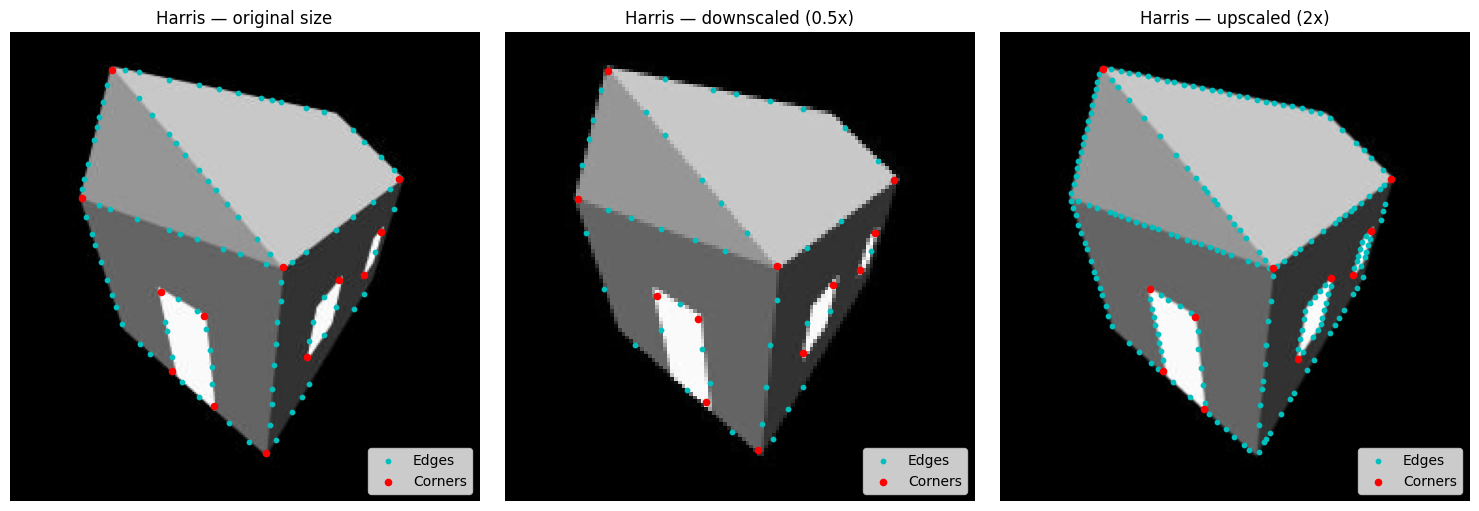

In [8]:
# Resize test: Downscale,  Upscale 

# Create scaled versions (resize 0.5 and 2.0)
down = cv2.resize(img_gray, dsize=None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
up   = cv2.resize(img_gray, dsize=None, fx=2.0, fy=2.0, interpolation=cv2.INTER_LINEAR)

# Harris on original, img_gray
corners_orig, edges_orig, R_orig, Rn_orig = harris_corners(
    img_gray, k=0.05, sigma=1.5,
    nms_ksize=7,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.001,
    refine=False
)

# Harris on downscaled, down
corners_down, edges_down, R_down, Rn_down = harris_corners(
    down, k=0.05, sigma=1.5,
    nms_ksize=7,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.001,
    refine=False
)

# Harris on upscaled, up
corners_up, edges_up, R_up, Rn_up = harris_corners(
    up, k=0.05, sigma=1.5,
    nms_ksize=7,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.001,
    refine=False
)

# Show plots
plt.figure(figsize=(15,5))

# Original
plt.subplot(1,3,1)
plt.imshow(img_gray, cmap='gray')
if len(edges_orig):
    plt.scatter(edges_orig[:,0], edges_orig[:,1], s=10, c='c', label='Edges')
if len(corners_orig):
    plt.scatter(corners_orig[:,0], corners_orig[:,1], s=20, c='r', label='Corners')
plt.title("Harris — original size")
plt.axis('off')
plt.legend(loc='lower right', frameon=True)

# Downscaled
plt.subplot(1,3,2)
plt.imshow(down, cmap='gray')
if len(edges_down):
    plt.scatter(edges_down[:,0], edges_down[:,1], s=10, c='c', label='Edges')
if len(corners_down):
    plt.scatter(corners_down[:,0], corners_down[:,1], s=20, c='r', label='Corners')
plt.title("Harris — downscaled (0.5x)")
plt.axis('off')
plt.legend(loc='lower right', frameon=True)


# Upscaled
plt.subplot(1,3,3)
plt.imshow(up, cmap='gray')
if len(edges_up):
    plt.scatter(edges_up[:,0], edges_up[:,1], s=10, c='c', label='Edges')
if len(corners_up):
    plt.scatter(corners_up[:,0], corners_up[:,1], s=20, c='r', label='Corners')
plt.title("Harris — upscaled (2x)")
plt.axis('off')
plt.legend(loc='lower right', frameon=True)

plt.tight_layout()
plt.show()


## Compare with OpenCV’s built-in Harris detector

OpenCV Harris (dilate + threshold)

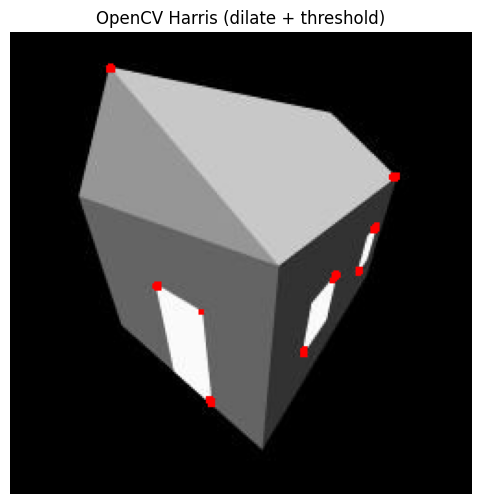

In [9]:
# Harris response
harris = cv2.cornerHarris(src=img_gray, blockSize=3, ksize=3, k=0.04)

# Dilate to emphasize local maxima
harris_dil = cv2.dilate(harris, None)

# Threshold & mark corners in red
thr = 0.1 * harris_dil.max()
img_vis = img_rgb.copy()
img_vis[harris_dil > thr] = [255, 0, 0]

# Show plot
plt.figure(figsize=(8, 6))
plt.imshow(img_vis)
plt.title("OpenCV Harris (dilate + threshold)")
plt.axis("off")
plt.show()


### Experiment with parameter tuning.

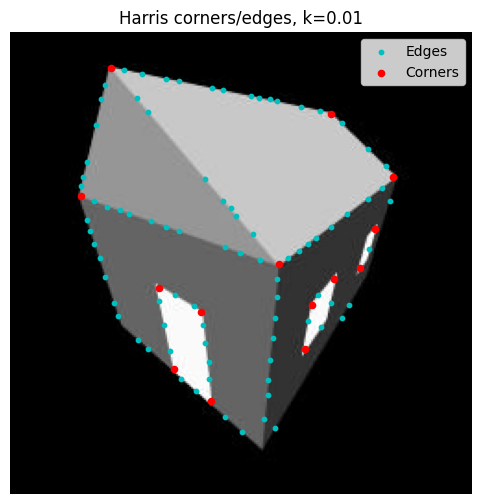

In [10]:
# Changing k=0.01, a penalty for gradients intensity

corners_xy, edges_xy, R, Rn = harris_corners(
    img_gray, k=0.01, sigma=1.5,
    nms_ksize=7,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.001,  
    refine=False
)

# Scatter-plot for edges and corners 

plt.figure(figsize=(8,6))
plt.imshow(img_gray, cmap='gray')
if len(edges_xy):
    plt.scatter(edges_xy[:,0], edges_xy[:,1], s=10, c='c', label='Edges')
if len(corners_xy):
    plt.scatter(corners_xy[:,0], corners_xy[:,1], s=20, c='r', label='Corners')
plt.legend()
plt.title("Harris corners/edges, k=0.01")
plt.axis('off')
plt.show()


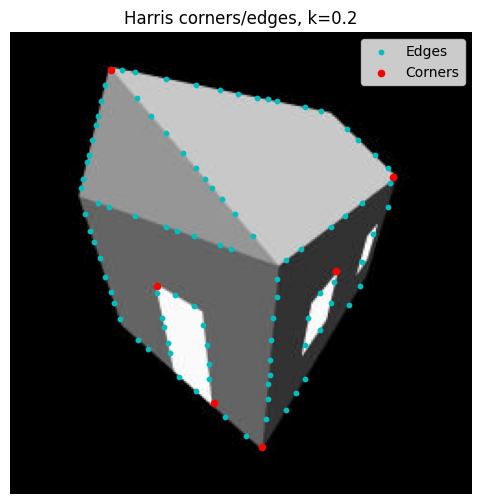

In [11]:
# Changing k=0.2, a penalty for gradients intensity

corners_xy, edges_xy, R, Rn = harris_corners(
    img_gray, k=0.2, sigma=1.5,
    nms_ksize=7,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.001,  
    refine=False
)

# Scatter-plot for edges and corners 

plt.figure(figsize=(8,6))
plt.imshow(img_gray, cmap='gray')
if len(edges_xy):
    plt.scatter(edges_xy[:,0], edges_xy[:,1], s=10, c='c', label='Edges')
if len(corners_xy):
    plt.scatter(corners_xy[:,0], corners_xy[:,1], s=20, c='r', label='Corners')
plt.legend()
plt.title("Harris corners/edges, k=0.2")
plt.axis('off')
plt.show()

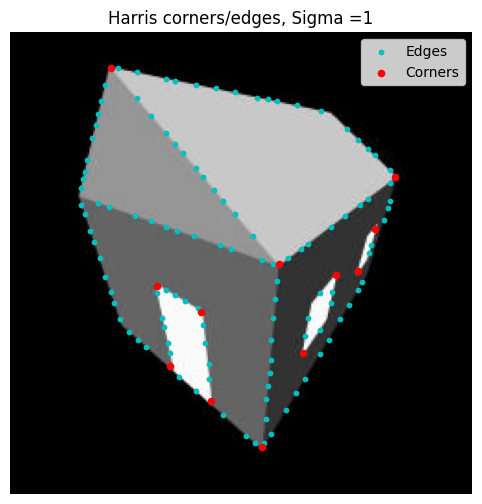

In [13]:
# Changing Sigma=1

corners_xy, edges_xy, R, Rn = harris_corners(
    img_gray, k=0.05, sigma=1,
    nms_ksize=7,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.001,  
    refine=False
)

# Scatter-plot for edges and corners 

plt.figure(figsize=(8,6))
plt.imshow(img_gray, cmap='gray')
if len(edges_xy):
    plt.scatter(edges_xy[:,0], edges_xy[:,1], s=10, c='c', label='Edges')
if len(corners_xy):
    plt.scatter(corners_xy[:,0], corners_xy[:,1], s=20, c='r', label='Corners')
plt.legend()
plt.title("Harris corners/edges, Sigma =1")
plt.axis('off')
plt.show()


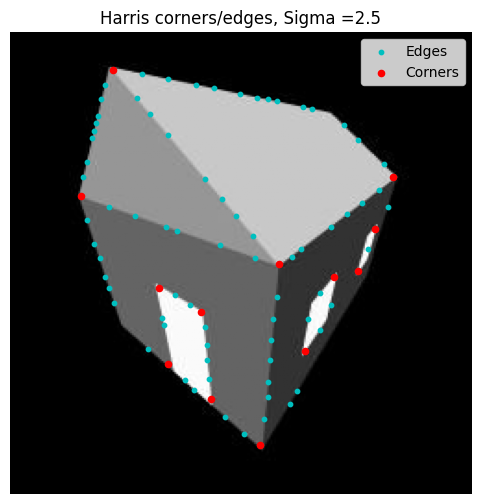

In [14]:
# Changing Sigma =2.5

corners_xy, edges_xy, R, Rn = harris_corners(
    img_gray, k=0.05, sigma=2.5,
    nms_ksize=7,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.001,  
    refine=False
)

# Scatter-plot for edges and corners 

plt.figure(figsize=(8,6))
plt.imshow(img_gray, cmap='gray')
if len(edges_xy):
    plt.scatter(edges_xy[:,0], edges_xy[:,1], s=10, c='c', label='Edges')
if len(corners_xy):
    plt.scatter(corners_xy[:,0], corners_xy[:,1], s=20, c='r', label='Corners')
plt.legend()
plt.title("Harris corners/edges, Sigma =2.5")
plt.axis('off')
plt.show()

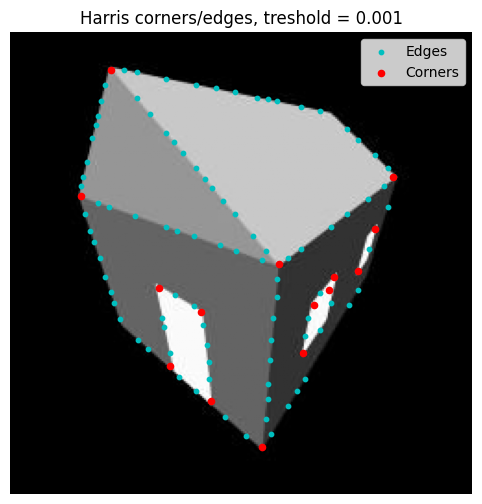

In [15]:
# Changing R corner and Edges treshhoload =0.001

corners_xy, edges_xy, R, Rn = harris_corners(
    img_gray, k=0.05, sigma=1.5,
    nms_ksize=7,
    corner_thresh_rel=0.001,  
    edge_thresh_rel=0.001,  
    refine=False
)

# Scatter-plot for edges and corners 

plt.figure(figsize=(8,6))
plt.imshow(img_gray, cmap='gray')
if len(edges_xy):
    plt.scatter(edges_xy[:,0], edges_xy[:,1], s=10, c='c', label='Edges')
if len(corners_xy):
    plt.scatter(corners_xy[:,0], corners_xy[:,1], s=20, c='r', label='Corners')
plt.legend()
plt.title("Harris corners/edges, treshold = 0.001")
plt.axis('off')
plt.show()

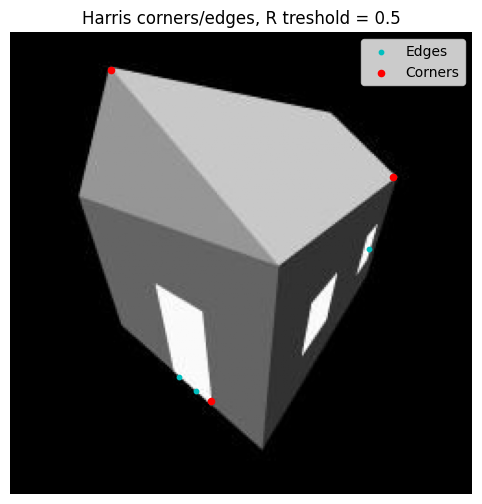

In [16]:
# Changing R corners and edges treshhoload =0.5

corners_xy, edges_xy, R, Rn = harris_corners(
    img_gray, k=0.05, sigma=1.5,
    nms_ksize=7,
    corner_thresh_rel=0.5,  
    edge_thresh_rel=0.5,  
    refine=False
)

# Scatter-plot for edges and corners 

plt.figure(figsize=(8,6))
plt.imshow(img_gray, cmap='gray')
if len(edges_xy):
    plt.scatter(edges_xy[:,0], edges_xy[:,1], s=10, c='c', label='Edges')
if len(corners_xy):
    plt.scatter(corners_xy[:,0], corners_xy[:,1], s=20, c='r', label='Corners')
plt.legend()
plt.title("Harris corners/edges, R treshold = 0.5")
plt.axis('off')
plt.show()